In [1]:
%load_ext snakeviz

In [2]:
import gc

import numpy as np
import pandas as pd
import itertools

from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

import eli5
import shap
import os

from eli5.sklearn import PermutationImportance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
%%snakeviz

path = '/Users/adil/Downloads/all/'
data = pd.read_csv(path + 'application_train.csv')
data = data.drop(columns = ['SK_ID_CURR'])
data.head()

 
*** Profile stats marshalled to file '/var/folders/fv/9x820hgx2klf9vw1zsz4b2_c0000gn/T/tmpgbb69i3l'. 


In [4]:
print(data.shape)
data.head()

(307511, 121)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Cleaning

In [5]:
#Function to replace outliers in input data
def replace_outliers(df):
    #Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    if 'CODE_GENDER' in df:
        df = df[df['CODE_GENDER'] != 'XNA']

    #Replace outlier values with nan
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].map(lambda x: x if x <= 0 else np.nan) # Days employed were negative, however, some were positive (which represent nan)
    df['REGION_RATING_CLIENT_W_CITY'] = df['REGION_RATING_CLIENT_W_CITY'].map(lambda x: x if x >= 0 else np.nan) 
    df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].map(lambda x: x if x <= 5e6 else np.nan)
    df['AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].map(lambda x: x if x <= 10 else np.nan)
    df['OBS_30_CNT_SOCIAL_CIRCLE'] = df['OBS_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 40 else np.nan)
    df['OBS_60_CNT_SOCIAL_CIRCLE'] = df['OBS_60_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 50 else np.nan)
    df['DEF_30_CNT_SOCIAL_CIRCLE'] = df['DEF_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 100 else np.nan)
    
    return df

###### Recursive feature elimination

In [6]:
def rfe_selector(input_df, labels, drop_ratio = 0.5):
    drop_ratio = max(0,min(drop_ratio, 1))
    df = input_df.copy()
    num_feats = int(len(df.columns) * drop_ratio)
    df = impute_features(df, features ='All')    
    df = scale_features(df)
    selector = RFE(estimator=LogisticRegression(solver='saga', n_jobs=-1), n_features_to_select=num_feats, step=10, verbose=20)
    selector.fit(df, labels)
    rfe_support = selector.get_support()
    rfe_feature = df.loc[:,rfe_support].columns.tolist()
    print('RFE : ', str(len(rfe_feature)), 'selected features out of', str(len(rfe_feature)))
    del df, selector, rfe_feature
    return rfe_support

###### Random forest

In [7]:
def rf_selector(df, labels):
    model = RandomForestClassifier(n_estimators=150)
    model.fit(df, labels)
    return model.feature_importances_

###### RF Classifier

In [8]:
#Funtion that performs 10 fold cv on input data and returns AUC score
def RF_Classifier(df, labels, num_splits = 10):
    probas_ = np.zeros(df.shape[0])
    # Run classifier with cross-validation
    cv = StratifiedKFold(n_splits=num_splits)

    for trainSet, testSet in cv.split(df, labels):
        rf_clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1).fit(df.iloc[trainSet], labels.iloc[trainSet])
        probas_[testSet] = rf_clf.predict_proba(df.iloc[testSet])[:,1]
        del rf_clf

    return roc_auc_score(labels, probas_)

###### Light GBM

In [9]:
def lgbm_selector(df, labels):
    clf = LGBMClassifier(n_jobs=-1, silent=True)
    model = clf.fit(df, labels, eval_metric = 'auc', verbose= False, early_stopping_rounds= 200)
    model.fit(df, labels)
    return model.feature_importances_

###### impute features; for missing data

In [10]:
def impute_features(df, features = 'All'):
    categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
    if(features == 'All'):
        feature_list = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'Unnamed :0']]
    elif(features == 'Numerical'):
        feature_list = floatingPoint_feats + integer_feats
    elif(features == 'Categorical'):
        feature_list = categorical_feats + bool_feats
    else:
        raise ValueError('features can either be All, Numerical, Categorical')
        
    #Imputer for numerical features
    imputer = Imputer(strategy = 'median')
    
    for feature in feature_list:
        if (feature in categorical_feats + bool_feats):
            df[feature] = df[feature].fillna(df[feature].value_counts().index[0])
        else:
            imputer.fit(df[feature].values.reshape(-1,1))
            df[feature] = imputer.transform(df[feature].values.reshape(-1,1))

    return df

###### Scale feature

In [11]:
def scale_features(df, feature_list = None, scale_range = (0,1)):
    if(feature_list == None):
        feature_list = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'Unnamed :0']]
        
    #Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = scale_range)
    
    for feature in feature_list:
        if (df[feature].dtype == 'object'):
            continue

        scaler.fit(df[feature].values.reshape(-1,1))
        df[feature] = scaler.transform(df[feature].values.reshape(-1,1))
    
    return df

###### Weight of evidence; considering multiple sources of information

In [12]:
#Function to caluculate WOE
def calculate_WOE(df, target,feature):
    lst = []
    for i in range(df[feature].nunique(dropna=False)):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (target == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (target == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    return data

In [13]:
#Function to identify feature types in a given data frame
def identify_feature_types(df, features_to_ignore, verbose = False):
    categorical_features = list(f for f in df.select_dtypes(include='object') if f not in features_to_ignore)
    floatingPoint_features = list(f for f in df.select_dtypes(include='float64') if f not in features_to_ignore)
    temp = list(f for f in df.select_dtypes(include='int64') if f not in features_to_ignore)
    bool_features = [x for x in temp if 'FLAG' in x]
    integer_features = [x for x in temp if x not in bool_features]
    totalCount = len(categorical_features) + len(floatingPoint_features) + len(bool_features) + len(integer_features)
    if (verbose == True):
        print ('Catagorical Features : {}, Floating Point Features : {}, Boolean Features : {}, Integer Features : {}, Total Count : {}'
           .format(len(categorical_features), len(floatingPoint_features), len(bool_features), len(integer_features), totalCount))
    
    return categorical_features, floatingPoint_features, bool_features, integer_features

###### Stratified Sampling

In [14]:
def take_sample(input_df, labels, stratified = True):
    df = input_df.copy()
    df['TARGET'] = labels
    num_samples = df.loc[df.TARGET==1].shape[0]

#     sampling_ratio = num_samples / df.shape[0]
    sample1 = df.loc[df.TARGET==1].sample(frac = 0.4, replace=False)
    print('label 1 sample size:', str(sample1.shape[0]))
    sample0 = df.loc[df.TARGET==0].sample(frac = 0.4, replace=False)
    print('label 0 sample size:', str(sample0.shape[0]))

    sampled_df = pd.concat([sample1, sample0], axis=0)
    sampled_labels = sampled_df.pop('TARGET')
    del df
    return sampled_df, sampled_labels

###### Get rid of outliers

In [15]:
%%snakeviz
data2 = replace_outliers(data)

/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



 
*** Profile stats marshalled to file '/var/folders/fv/9x820hgx2klf9vw1zsz4b2_c0000gn/T/tmps2exkf9k'. 


In [16]:
%%time
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(data2,
                                                                            ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
for cat_feature in categorical_feats:
    WoE_df = calculate_WOE(data2, 'TARGET', cat_feature)
    data2[cat_feature] = data2[cat_feature].replace(WoE_df.set_index('Value')['WoE'])

/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


CPU times: user 41.7 s, sys: 5.48 s, total: 47.2 s
Wall time: 47.8 s


In [17]:
data2.shape

(307507, 121)

In [18]:
data2.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,-0.036222,-0.250917,-0.056238,0.015087,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,-0.036222,0.154321,-0.056238,-0.033475,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.415413,-0.250917,0.117347,0.015087,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,-0.036222,0.154321,-0.056238,0.015087,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,-0.036222,-0.250917,-0.056238,0.015087,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


###### Separate Train/Val & Test

In [27]:
data2_tr_val = data2[:np.int(0.8*len(data2))]

In [32]:
data2_tr_val.shape

(246005, 121)

In [34]:
data2_test = data2[np.int(0.8*len(data2))+1: len(data2)]

In [35]:
data2_test.shape

(61501, 121)

In [36]:
y = data2_tr_val.pop('TARGET')
# file3.shape

In [37]:
data_scaled = impute_features(data2_tr_val)
data_scaled = scale_features(data_scaled)

/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
# data_scaled, y = take_sample(data_scaled, y)

In [38]:
score = RF_Classifier(data_sRF_Classifiercaled, y, 5)

In [39]:
score

0.71043386103077966

In [ ]:
# train_X, val_X, train_y, val_y = train_test_split(data_scaled, y, random_state = 1)

In [ ]:
# rf_model = RandomForestClassifier(n_estimators=100, random_state=1).fit(train_X, train_y)

In [ ]:
# prediction_rf = rf_model.predict_proba(val_X)[:,1]

In [ ]:
# rf_roc_auc = roc_auc_score(val_y, prediction_rf)
# rf_roc_auc

### Bayesian Optimisation of RF model

###### RF Parameters

In [40]:
# # from that dimension (`'log-uniform'` for the learning rate)
# space  = [Integer(25, 250, name = 'n_estimators'),
#           Categorical(['gini', 'entropy'], name = 'criterion'),
# #           Integer(50, 200, name = 'max_depth'),
#           Integer(2, 60,  name = 'min_samples_split'),
#           Integer(1, 5, name = 'min_samples_leaf'),
# #           Real(0.6, 0.9, name = 'min_weight_fraction_leaf'),
# #           Real(0.01, 2, 0.001, name = 'max_features'), 
# #           Integer(80, 120, name = 'max_leaf_nodes'),
# #           Integer(100, 1000, name = 'min_impurity_decrease')
#           Categorical([True, False], name = 'bootstrap'),
#           Categorical([True, False], name = 'oob_score'),
# #           Real(-1, 1, name = 'n_jobs'),
# #           Real(0, 1, name = 'random_state'),
# #           Real(,  , name = 'verbose'),
#           Categorical([True, False], name = 'warm_start')
# #           xxx(, , name = 'class_weight') 
#          ]

In [57]:
# AFTER PARFIT

# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(250, 325, name = 'n_estimators'),
          Categorical(['entropy'], name = 'criterion'),
#           Integer(50, 200, name = 'max_depth'),
          Integer(50, 70,  name = 'min_samples_split'),
          Integer(4, 15, name = 'min_samples_leaf'),
#           Real(0.6, 0.9, name = 'min_weight_fraction_leaf'),
#           Real(0.01, 2, 0.001, name = 'max_features'), 
#           Integer(80, 120, name = 'max_leaf_nodes'),
#           Integer(100, 1000, name = 'min_impurity_decrease')
          Categorical([True, False], name = 'bootstrap'),
          Categorical([False], name = 'oob_score'),
#           Real(-1, 1, name = 'n_jobs'),
#           Real(0, 1, name = 'random_state'),
#           Real(,  , name = 'verbose'),
          Categorical([False], name = 'warm_start')
#           xxx(, , name = 'class_weight') 
         ]

In [58]:
def objective(values):
    
    params = {'n_estimators': values[0], 
              'criterion': values[1], 
              'min_samples_split': values[2], 
              'min_samples_leaf': values[3],
#               'bootstrap': values[4],
              'oob_score': values[5],
              'warm_start': values[6]
              }
    
    print('\nNext set of params.....', params)
    
    train_X, val_X, train_y, val_y = train_test_split(data_scaled, y)
    
    rf_model = RandomForestClassifier(**params, n_jobs = -1).fit(train_X, train_y)
    
    auc = -roc_auc_score(val_y, rf_model.predict_proba(val_X)[:,1])
    
    print("\nAUROC.....", -auc)
    
    gc.collect()
    
    return  auc

In [59]:
res_gp = gp_minimize(objective, space, n_calls=20, random_state = 0, n_random_starts = 10, n_jobs = -1)

print("Best score=%.4f" % res_gp.fun)
print("Best params: ", res_gp.x)


Next set of params..... {'n_estimators': 294, 'criterion': 'entropy', 'min_samples_split': 67, 'min_samples_leaf': 13, 'oob_score': False, 'warm_start': False}

AUROC..... 0.745789170529

Next set of params..... {'n_estimators': 254, 'criterion': 'entropy', 'min_samples_split': 60, 'min_samples_leaf': 13, 'oob_score': False, 'warm_start': False}

AUROC..... 0.745547131339

Next set of params..... {'n_estimators': 275, 'criterion': 'entropy', 'min_samples_split': 57, 'min_samples_leaf': 15, 'oob_score': False, 'warm_start': False}

AUROC..... 0.744540593457

Next set of params..... {'n_estimators': 310, 'criterion': 'entropy', 'min_samples_split': 64, 'min_samples_leaf': 12, 'oob_score': False, 'warm_start': False}

AUROC..... 0.746197870309

Next set of params..... {'n_estimators': 258, 'criterion': 'entropy', 'min_samples_split': 54, 'min_samples_leaf': 12, 'oob_score': False, 'warm_start': False}

AUROC..... 0.74463115034

Next set of params..... {'n_estimators': 261, 'criterion': '

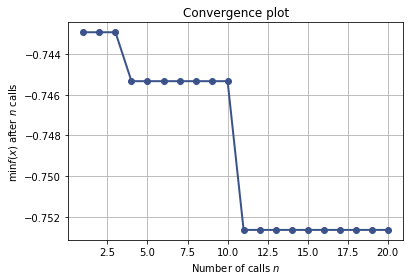

In [43]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [60]:
newRF_model = RandomForestClassifier(n_estimators = 314, criterion = 'entropy', min_samples_split = 50, \
                                   min_samples_leaf = 15, oob_score = False, warm_start = False, n_jobs = -1)
newRF_model.fit(data_scaled, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=314, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
%%time
data2_test_scaled = impute_features(data2_test)
data2_test_scaled = scale_features(data2_test)

/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adil/anaconda3/envs/python36_v2/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

CPU times: user 11.4 s, sys: 157 ms, total: 11.5 s
Wall time: 11.6 s


In [ ]:
# data_scaled = impute_features(data2_tr_val)
# data_scaled = scale_features(data_scaled)

In [47]:
y_target = data2_test_scaled.pop('TARGET')

In [61]:
pred = newRF_model.predict_proba(data2_test_scaled)[:,1]
# pred
roc_auc_score_2 = roc_auc_score(y_target, pred)
roc_auc_score_2

0.74437718623652172

In [53]:
newRF_model2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
newRF_model2.fit(data_scaled, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
pred = newRF_model2.predict_proba(data2_test_scaled)[:,1]
# pred
roc_auc_score_3 = roc_auc_score(y_target, pred)
roc_auc_score_3

0.69648469137359403

### Parfit Optimisation on RF

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 20.5min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed: 23.9min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 26.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.3min finished


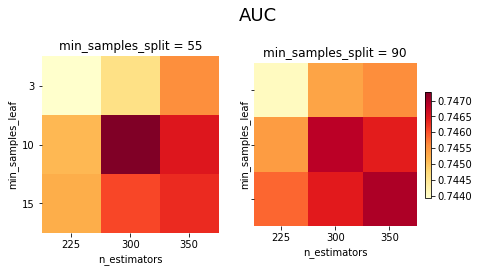

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=55,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 0.747288799401


In [56]:
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf

grid = {
    'n_estimators': [225, 300, 350],
    'criterion' :['entropy'],
    'min_samples_split': [55, 90],
    'min_samples_leaf' : [3, 10, 15],
    'oob_score': [False],
    'warm_start' : [False],
    'n_jobs' : [-1]
    }
paramGrid = ParameterGrid(grid)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, y, test_size = 0.33, random_state = 42)

bestModel, bestScore, allModels, allScores = pf.bestFit(RandomForestClassifier(), paramGrid,
           X_train, y_train, X_test, y_test, 
           metric = roc_auc_score, greater_is_better = True,
           predict_proba = True, scoreLabel = "AUC")

print(bestModel, bestScore)